In [3]:
import configparser, docker, time, re
config = configparser.ConfigParser()
config.read('hometemp.ini')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from api.fetcher import DWDFetcher, UlmDeFetcher
from persist.database import DwDDataHandler, SensorDataHandler, GoogleDataHandler, UlmDeHandler, WetterComHandler
from util.manager import DockerManager, PostgresDockerManager
from visualize.plots import draw_plots

auth = config["db"]


In [4]:
ulmde_handler = UlmDeHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'ulmde_data')
ulmde_handler.init_db_connection()
ulmde_df = ulmde_handler.read_data_into_dataframe()
ulmde_df['timestamp'] = ulmde_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
ulmde_df

,id,timestamp,temp
0,1,2023-10-03 09:01:53,16.0
1,2,2023-10-03 09:11:52,16.0
2,3,2023-10-03 09:21:54,16.0
3,4,2023-10-03 09:31:56,16.0
4,5,2023-10-03 09:41:58,16.0
...,...,...,...
45239,45272,2024-08-27 20:10:39,22.0
45240,45273,2024-08-27 20:20:41,20.0
45241,45274,2024-08-27 20:30:45,20.0
45242,45275,2024-08-27 20:40:48,20.0


In [5]:
dwd_handler = DwDDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'dwd_data')
dwd_handler.init_db_connection()
dwd_df = dwd_handler.read_data_into_dataframe()
dwd_df['timestamp'] = dwd_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
dwd_df = dwd_df.sort_values(by="timestamp")

dwd_df.drop(['id', 'timestamp'],axis=1).describe()

,temp,temp_dev
count,8273.000000,8273.000000
mean,10.619171,11.217213
std,7.666212,2.026143
min,-10.100000,0.000000
25%,5.200000,9.000000
50%,9.900000,11.000000
75%,16.400000,12.000000
max,31.000000,20.000000


In [6]:
wettercom_handler = WetterComHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'],'wettercom_data')
wettercom_handler.init_db_connection()
wettercom_df = wettercom_handler.read_data_into_dataframe()
wettercom_df['timestamp'] = wettercom_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
wettercom_df

,id,timestamp,temp_stat,temp_dyn
0,1,2023-09-17 11:07:25,19.0,19.0
1,2,2023-09-17 11:17:24,19.0,19.0
2,3,2023-09-17 11:27:26,21.0,20.0
3,4,2023-09-17 11:37:27,21.0,21.0
4,5,2023-09-17 11:47:28,21.0,21.0
...,...,...,...,...
47605,47606,2024-08-27 20:10:37,23.0,22.0
47606,47607,2024-08-27 20:20:40,23.0,22.0
47607,47608,2024-08-27 20:30:43,23.0,22.0
47608,47609,2024-08-27 20:40:47,21.0,21.0


In [7]:

google_handler = GoogleDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'google_data')
google_handler.init_db_connection()
google_df = google_handler.read_data_into_dataframe()
google_df['timestamp'] = google_df['timestamp'].map(lambda x: datetime.strptime(re.sub('\..*', '', str(x).strip()), '%Y-%m-%d %H:%M:%S'))
google_df = google_df.sort_values(by="timestamp")

google_df

,id,timestamp,temp,humidity,precipitation,wind
0,4,2023-09-11 20:38:41,23.0,56.0,1.0,6.0
1,5,2023-09-11 20:48:42,22.0,64.0,1.0,8.0
2,6,2023-09-11 20:58:44,22.0,66.0,1.0,6.0
3,7,2023-09-11 21:08:45,22.0,66.0,1.0,6.0
4,8,2023-09-11 21:18:47,21.0,68.0,1.0,5.0
...,...,...,...,...,...,...
48107,48143,2024-08-27 20:10:40,22.0,66.0,2.0,11.0
48108,48144,2024-08-27 20:20:42,21.0,72.0,0.0,8.0
48109,48145,2024-08-27 20:30:46,21.0,73.0,2.0,8.0
48110,48146,2024-08-27 20:40:51,21.0,73.0,2.0,8.0


In [8]:
google_df.drop(['id', 'timestamp'],axis=1).describe()


,temp,humidity,precipitation,wind
count,48112.000000,48112.000000,48112.000000,48112.000000
mean,10.748088,77.827444,13.931452,10.890485
std,8.130198,16.103678,26.181859,6.183687
min,-14.000000,23.000000,0.000000,0.000000
25%,5.000000,68.000000,0.000000,6.000000
50%,10.000000,82.000000,2.000000,10.000000
75%,17.000000,90.000000,10.000000,14.000000
max,33.000000,100.000000,100.000000,43.000000


In [9]:
handler = SensorDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'sensor_data')
handler.init_db_connection(check_table=False)
df = handler.read_data_into_dataframe()
df['timestamp'] = df['timestamp'].map(lambda x : datetime.strptime(str(x).replace("+00:00", "").strip(), '%Y-%m-%d %H:%M:%S'))
df = df.sort_values(by='timestamp')
df = df.reset_index()
#print(str(df['timestamp'][0].month), str(df['timestamp'][0].day))

df

,index,id,timestamp,humidity,room_temp,cpu_temp
0,4,6481,2023-08-12 11:32:54,69.5,21.0,37.50
1,116,6482,2023-08-12 11:42:55,70.0,21.1,37.50
2,232,6483,2023-08-12 11:53:01,69.8,21.1,36.50
3,349,6484,2023-08-12 12:03:03,69.5,21.1,36.50
4,466,6485,2023-08-12 12:13:04,69.5,21.1,36.00
...,...,...,...,...,...,...
54194,54194,60739,2024-08-27 20:09:03,52.0,23.1,49.60
54195,54195,60740,2024-08-27 20:19:05,51.9,23.1,47.40
54196,54196,60741,2024-08-27 20:29:07,52.0,23.1,47.95
54197,54197,60742,2024-08-27 20:39:10,52.1,23.1,49.60


In [10]:
# measurement data collection started on 12th august 2023, 11 hours 32 minutes 54 seconds
assert df['timestamp'][0].day == 12 and df['timestamp'][0].month == 8 and df['timestamp'][0].year == 2023 and df['timestamp'][0].hour == 11 and df['timestamp'][0].minute == 32 and df['timestamp'][0].second == 54

In [11]:
df[["humidity", "room_temp", "cpu_temp"]].describe()

,humidity,room_temp,cpu_temp
count,54199.000000,54199.000000,54199.000000
mean,54.363300,18.943785,35.662176
std,7.259743,2.248756,2.751982
min,0.000000,11.400000,25.797000
25%,49.000000,17.500000,34.076000
50%,53.599998,18.700001,35.537000
75%,59.700001,20.100000,36.998000
max,78.199997,28.200001,65.000000


In [12]:
corr_matrix = df[["humidity", "room_temp", "cpu_temp"]].corr()
#corr_matrix = df[["humidity", "room_temp"]].corr()
corr_matrix

,humidity,room_temp,cpu_temp
humidity,1.000000,0.281835,0.130947
room_temp,0.281835,1.000000,0.797125
cpu_temp,0.130947,0.797125,1.000000


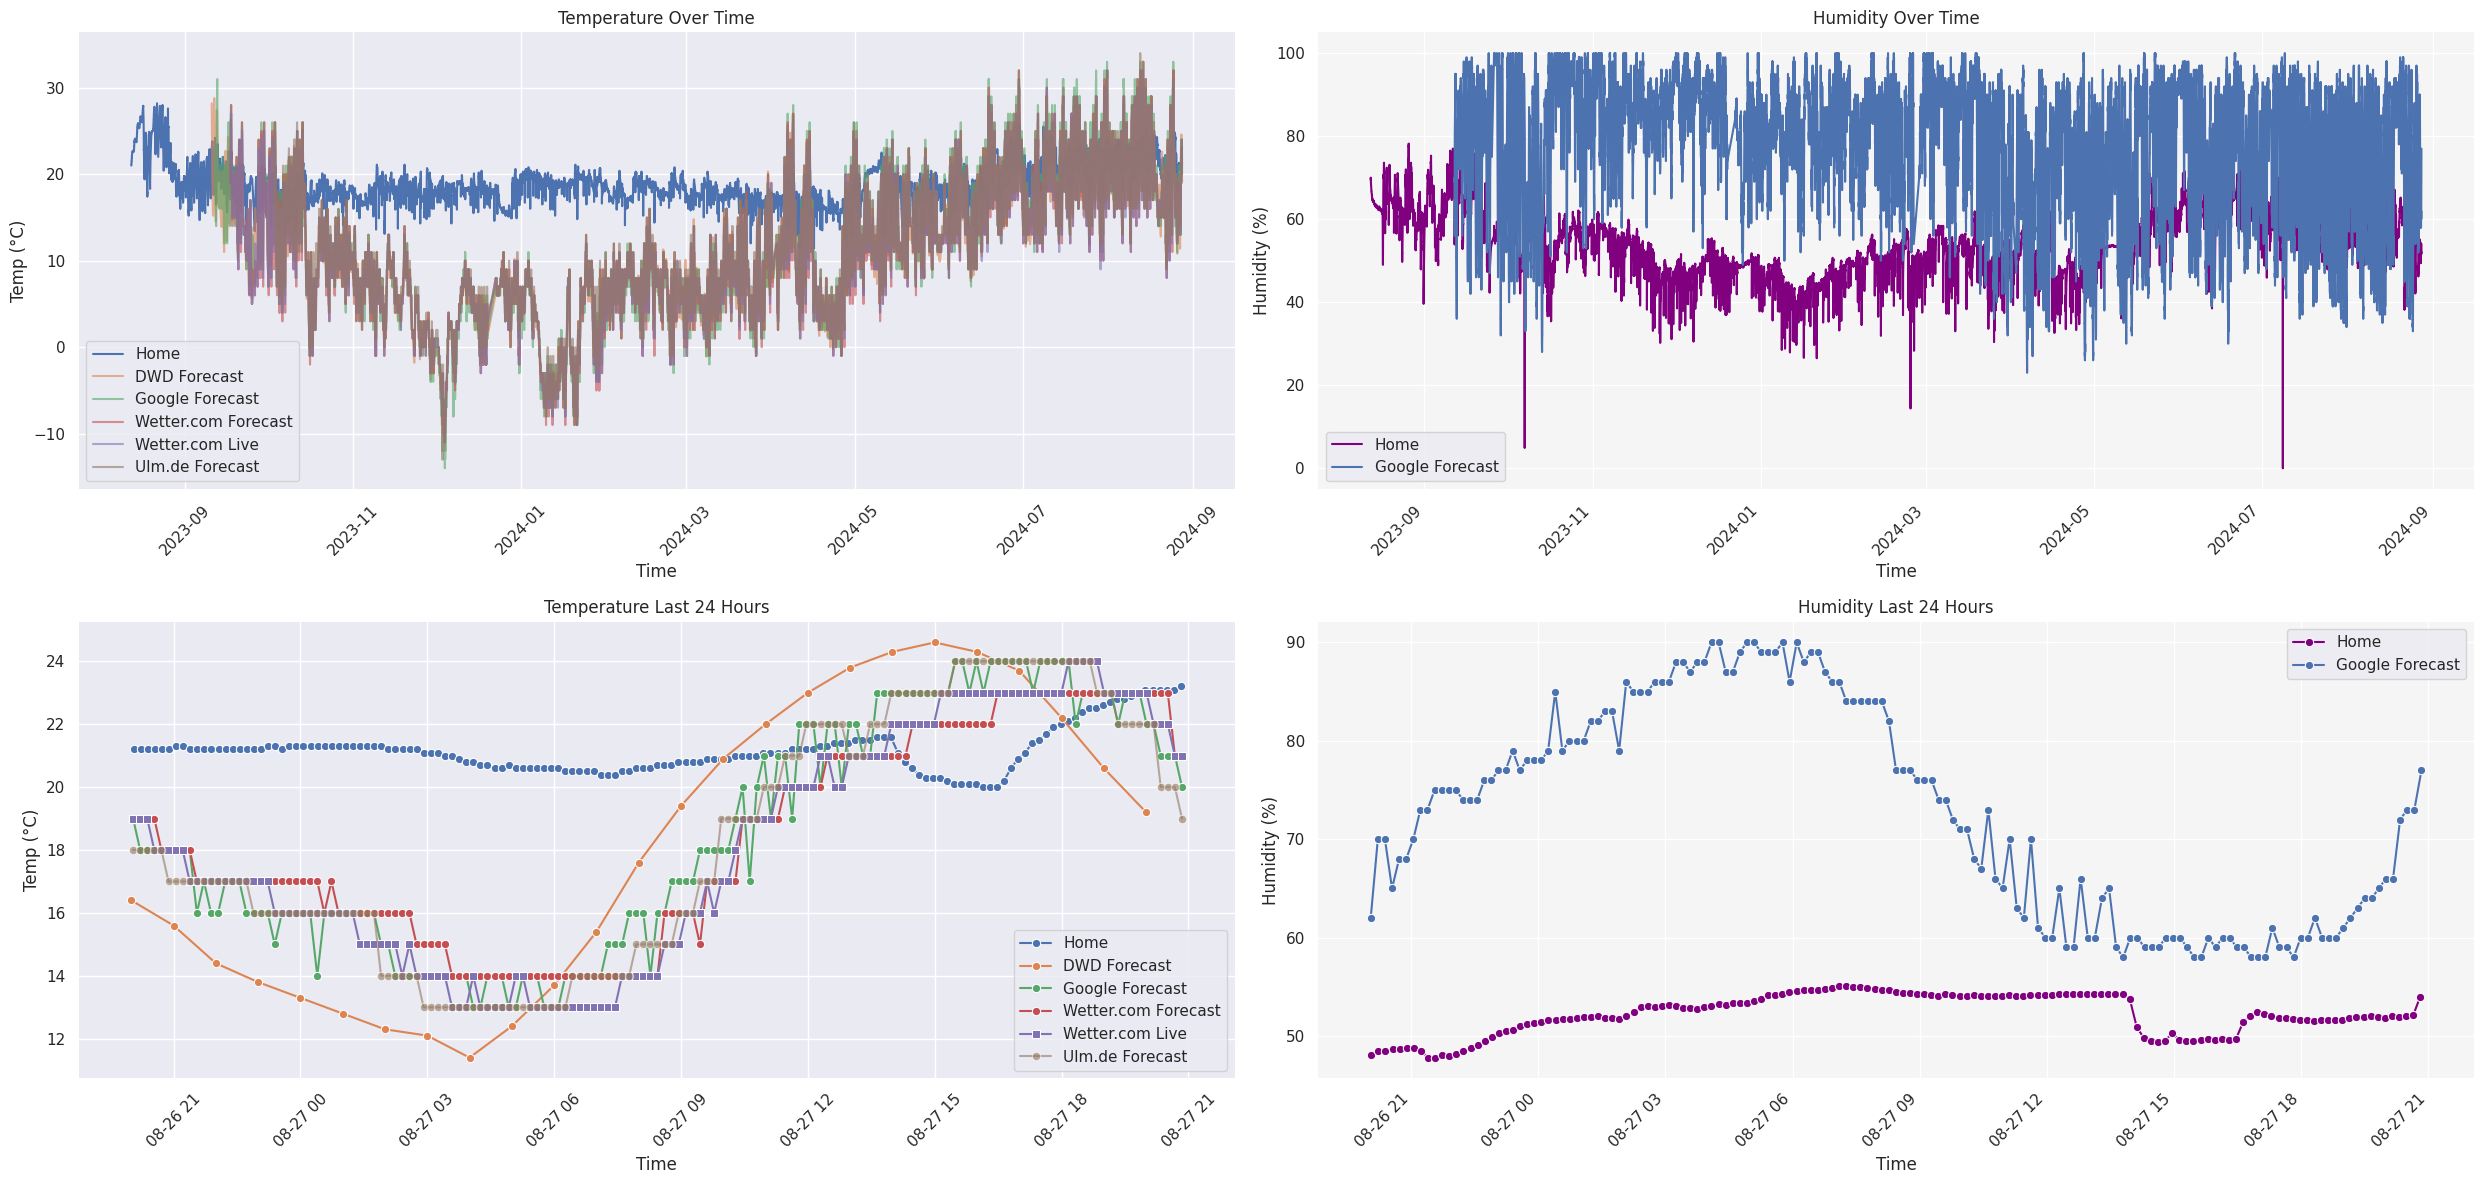

In [13]:
draw_plots(df,dwd_df=dwd_df,google_df=google_df,wettercom_df=wettercom_df,ulmde_df=ulmde_df, with_save=False)

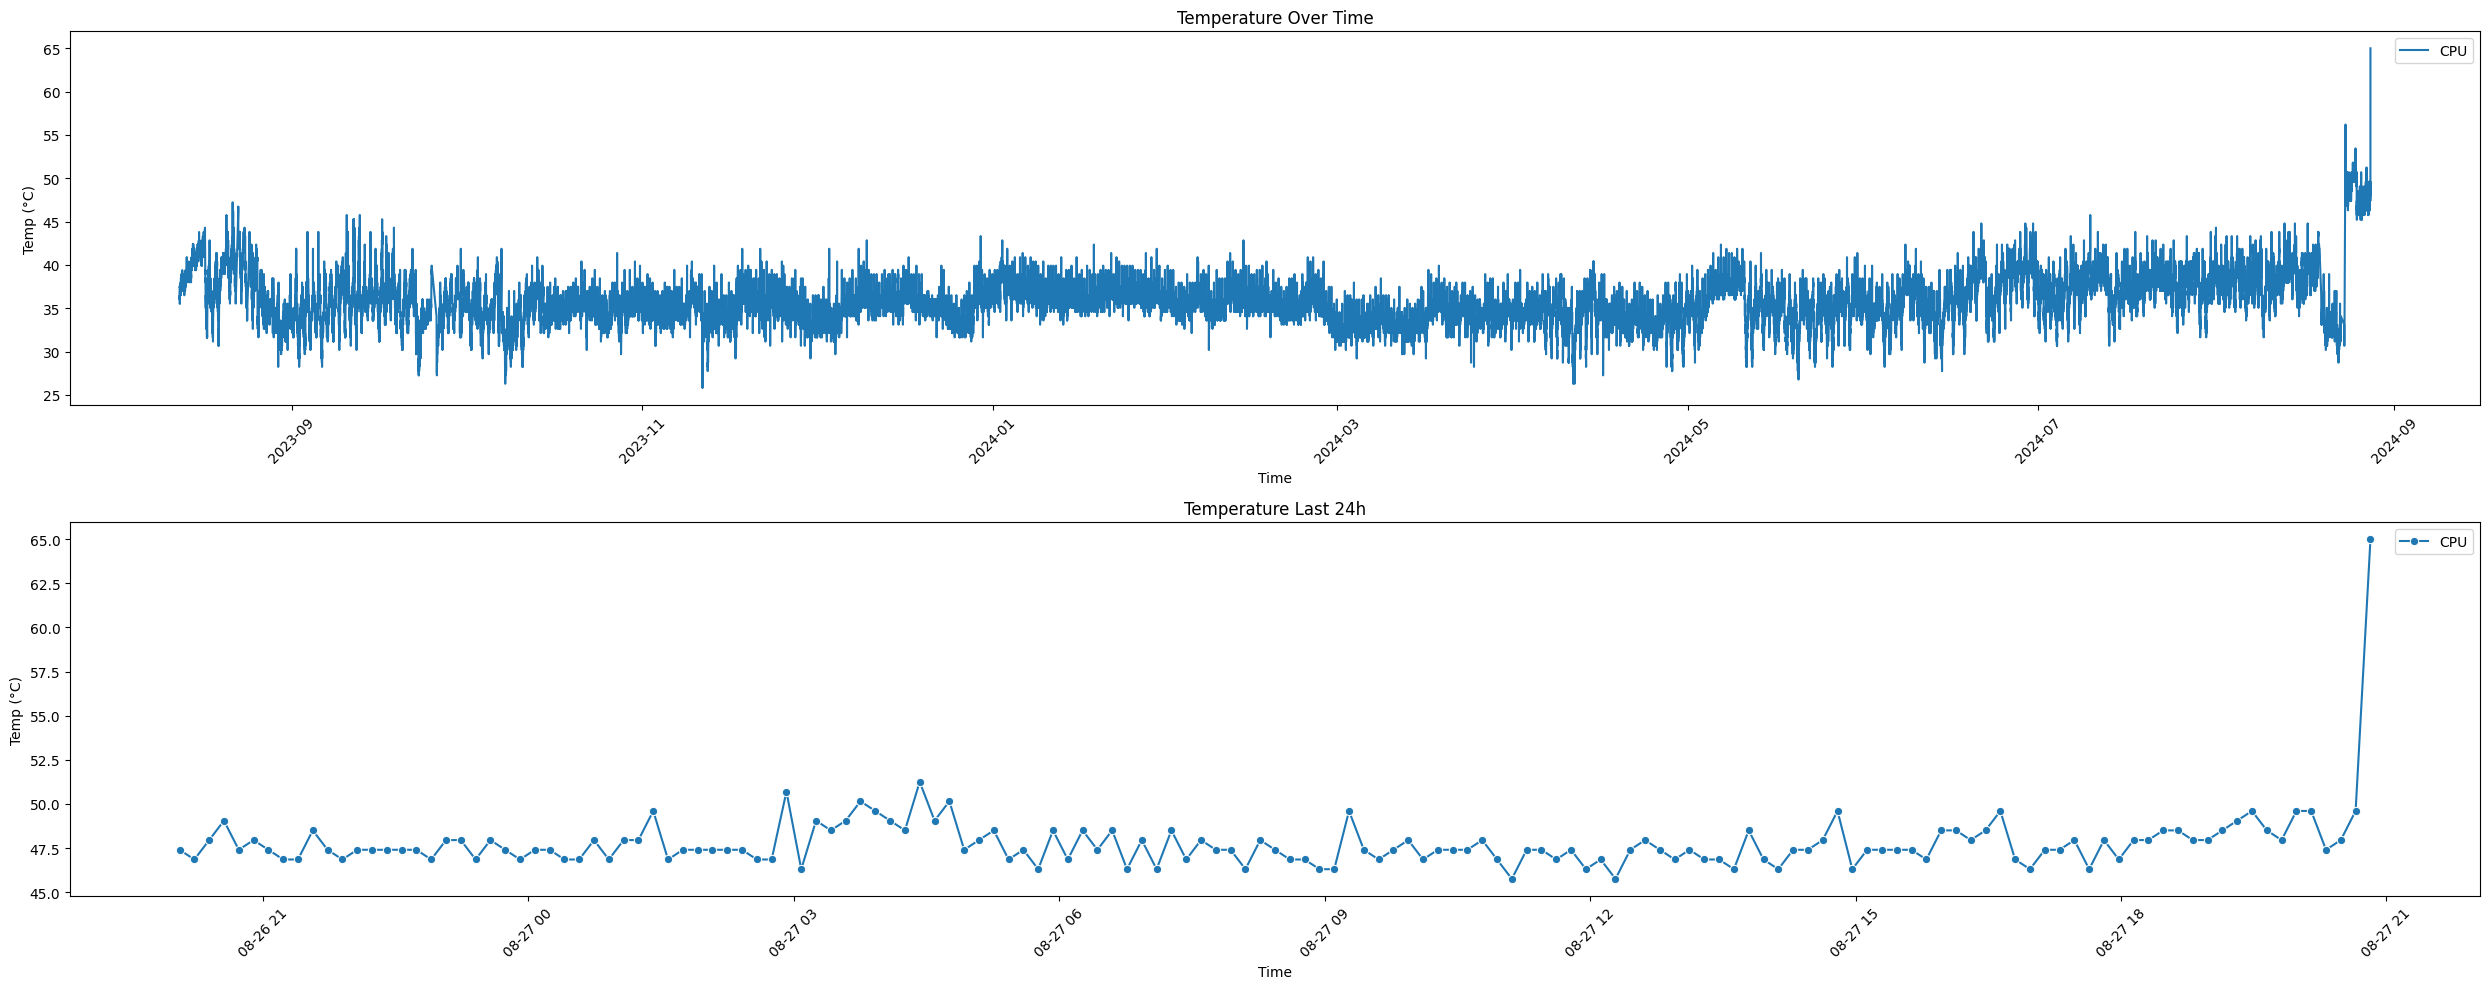

In [14]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)

sns.lineplot(label="CPU", x="timestamp", y="cpu_temp", data=df)
plt.title("Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Temp (°C)")
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.lineplot(label="CPU", x="timestamp", y="cpu_temp",marker='o',markersize=6, data=df[df["timestamp"] >= datetime.now() - timedelta(hours=25)])
plt.title("Temperature Last 24h")
plt.xlabel("Time")
plt.ylabel("Temp (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


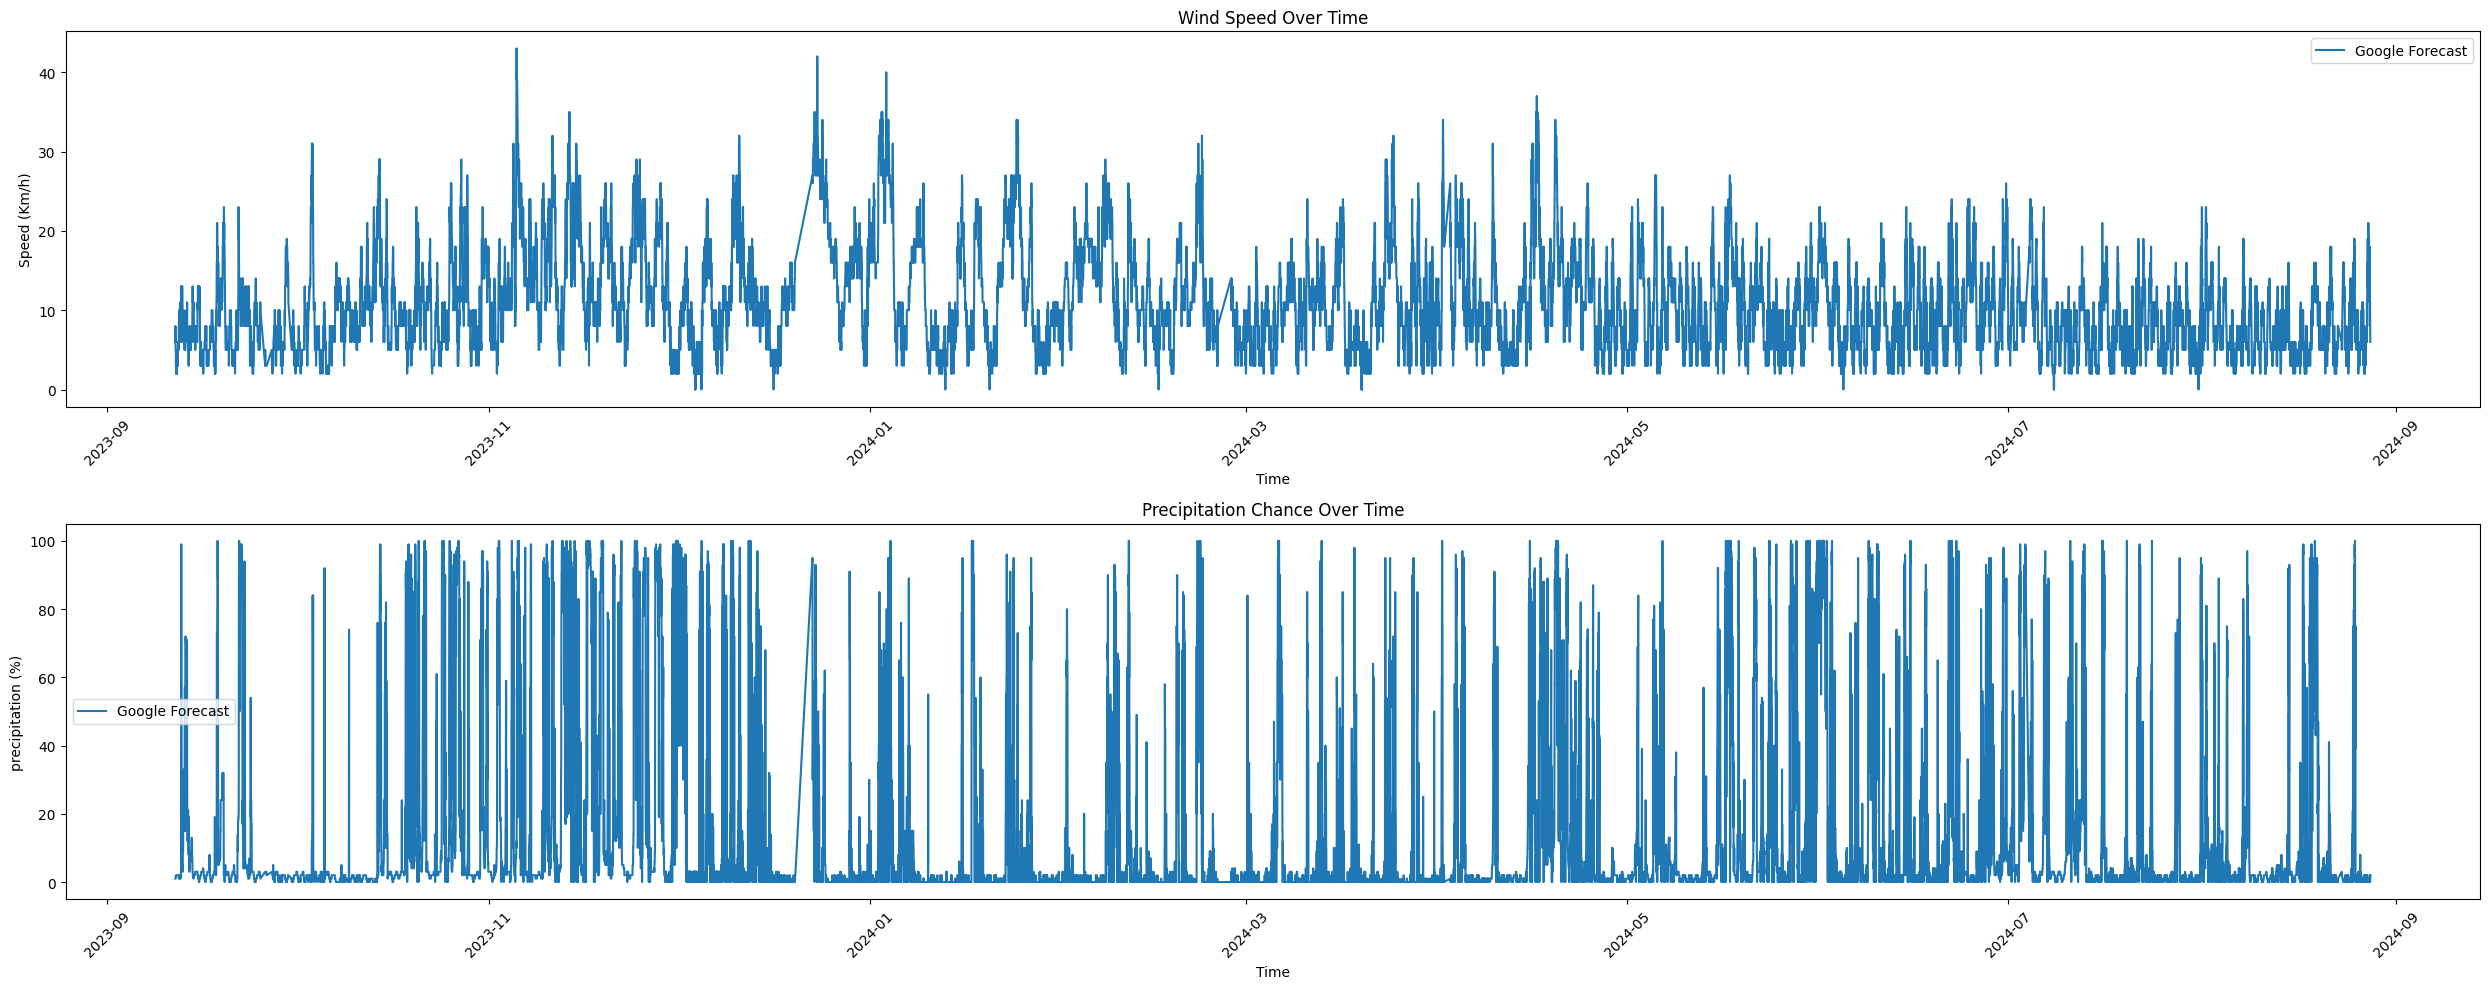

In [15]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
sns.lineplot(label="Google Forecast", x="timestamp", y="wind", data=google_df)
plt.title("Wind Speed Over Time")
plt.xlabel("Time")
plt.ylabel("Speed (Km/h)")
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.lineplot(label="Google Forecast", x="timestamp", y="precipitation", data=google_df)
plt.title("Precipitation Chance Over Time")
plt.xlabel("Time")
plt.ylabel("precipitation (%)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
fitness = pd.read_csv('fitness.csv')
fitness['time'] = fitness['time'].map(lambda x: datetime.strptime(x, "%d-%m-%Y"))
fitness['weight'] = fitness['weight'].map(lambda x: float(x))
fitness['bmi'] = fitness['bmi'].map(lambda x: float(x))
fitness['body_fat'] = fitness['body_fat'].map(lambda x: float(x))
fitness['muscle'] = fitness['muscle'].map(lambda x: float(x))
fitness['kcal'] = fitness['kcal'].map(lambda x: float(x))
fitness['visceral'] = fitness['visceral'].map(lambda x: float(x))
fitness = fitness.sort_values(by="time")

fitness.drop(['time'], axis=1).describe()

FileNotFoundError: [Errno 2] No such file or directory: 'fitness.csv'

In [ ]:
def plot_fitness(fitness):
    plt.figure(figsize=(25, 10))

    # Visualization 1: Line plot for weight over time
    plt.subplot(2, 2, 1)
    sns.lineplot(data=fitness, x='time', y='weight')
    plt.xticks(rotation=45)
    plt.title('Weight over Time')

    # Visualization 2: Line plot for BMI over time
    plt.subplot(2, 2, 2)
    sns.lineplot(data=fitness, x='time', y='bmi')
    plt.xticks(rotation=45)
    plt.title('BMI over Time')

    # Visualization 3: Line plot for body fat over time
    plt.subplot(2, 2, 3)
    sns.lineplot(data=fitness, x='time', y='body_fat')
    plt.xticks(rotation=45)
    plt.title('Body Fat over Time')

    # Visualization 4: Line plot for muscle over time
    plt.subplot(2, 2, 4)
    sns.lineplot(data=fitness, x='time', y='muscle')
    plt.xticks(rotation=45)
    plt.title('Muscle over Time')

    plt.tight_layout()
    plt.show()

def plot_fitness_corr(fitness):
    correlation_matrix = fitness[["weight", "bmi", "body_fat", "muscle", "kcal", "visceral"]].corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True,mask=mask, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()

plot_fitness(fitness)
plot_fitness_corr(fitness)

def plot_overall_heatmap():
    heat_df = pd.concat([
        df[df["timestamp"] >= datetime.now() - timedelta(hours=25)][["humidity", "room_temp", "cpu_temp"]].rename(lambda x: f"home_{x}", axis="columns"),
        google_df[google_df["timestamp"] >= datetime.now() - timedelta(hours=25)].drop(['id', 'timestamp'],axis=1).rename(lambda x: f"google_{x}", axis="columns"),
        dwd_df[dwd_df["timestamp"] >= datetime.now() - timedelta(hours=25)].drop(['id', 'timestamp'],axis=1).rename(lambda x: f"dwd_{x}", axis="columns")
    ])

    m = heat_df.corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(m, dtype=bool))
    sns.heatmap(m, annot=True,mask=mask, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    return m

#plot_overall_heatmap()